In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
from toy_mc.histogram import Histogram, plot_histogram

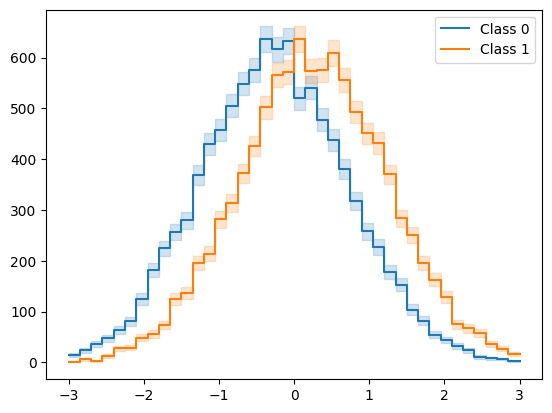

In [3]:
# generate samples from two shifted gaussians
np.random.seed(0)
x = np.concatenate([np.random.normal(-0.25, 1, 10000), np.random.normal(0.25, 1, 10000)])
# class labels for the samples
y = np.concatenate([np.zeros(10000), np.ones(10000)])
# Make Histogram for each class and fill with samples
hist0 = Histogram(bin_edges=np.linspace(-3, 3, 41))
hist0.fill(x[y == 0])
hist1 = Histogram(bin_edges=np.linspace(-3, 3, 41))
hist1.fill(x[y == 1])
# plot both distributions
fig, ax = plt.subplots()
plot_histogram(hist0, label="Class 0", ax=ax)
plot_histogram(hist1, label="Class 1", ax=ax)
plt.legend()
plt.show()


In [4]:
# import KNN classifier and train on the data
from surfaces.sample_weighted_kneighbors import SampleWeightedKNeighborsClassifier

In [17]:
knn = SampleWeightedKNeighborsClassifier(n_neighbors=500)
# Train the classifier
knn.fit(x[:, np.newaxis], y)
# predict the class probabilities for the samples (without bias correction)
y_pred = knn.predict_proba(x[:, np.newaxis], correct_bias=True)
# Get samples from class 0
x0 = x[y == 0]
# Calculate reweighting factors as the ratio of the class probabilities
w0 =  y_pred[y == 0, 1] / y_pred[y == 0, 0]


Chi2:  35.40927345237775


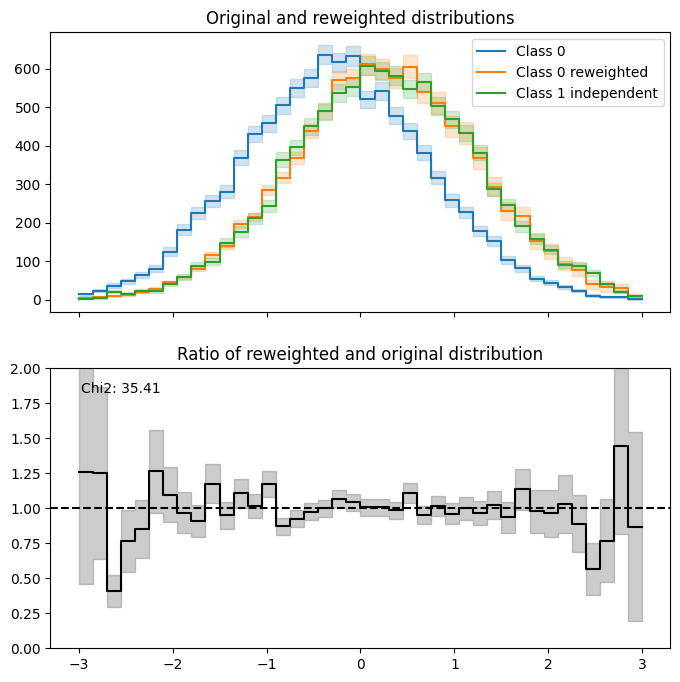

In [18]:
# Make new Histogram for class 0 and fill with samples and weights
hist0_reweighted = Histogram(bin_edges=np.linspace(-3, 3, 41))
hist0_reweighted.fill(x0, weights=w0)
# Generate another sample from the same distribution as that of class 1
x1 = np.random.normal(0.25, 1, 10000)
# Make Histogram for class 1 and fill with samples
hist1_independent = Histogram(bin_edges=np.linspace(-3, 3, 41))
hist1_independent.fill(x1)
# Make plot with two panels. Upper panel shows the original distributions and the
# reweighted distribution for class 0. Lower panel shows the ratio of the
# distributions.
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
plot_histogram(hist0, label="Class 0", ax=ax[0])
plot_histogram(hist0_reweighted, label="Class 0 reweighted", ax=ax[0])
# plot_histogram(hist1, label="Class 1", ax=ax[0])
plot_histogram(hist1_independent, label="Class 1 independent", ax=ax[0])
ax[0].legend()
ax[0].set_title("Original and reweighted distributions")
# Divide the Histograms
# ratio = hist0_reweighted / hist1
ratio = hist0_reweighted / hist1_independent
# Plot the ratio
plot_histogram(ratio, ax=ax[1], color="k")
ax[1].set_title("Ratio of reweighted and original distribution")
ax[1].set_ylim(0, 2)
ax[1].axhline(1, color="k", linestyle="--")
# calculate chi-square between the reweighted and the newly drawn distribution
# from class 1
chi2 = (hist0_reweighted.hist - hist1_independent.hist) ** 2 / (hist1_independent.hist_unc**2 + hist0_reweighted.hist_unc**2)
# print and add to lower panel
print("Chi2: ", np.sum(chi2))
ax[1].text(0.05, 0.95, "Chi2: {:.2f}".format(np.sum(chi2)), transform=ax[1].transAxes, va="top")
plt.show()